In [56]:
import sympy as sp
from sympy import diff, Symbol
from scipy.integrate import odeint
import scipy as si
import numpy as np
from sympy.physics.mechanics import dynamicsymbols
import math

In [57]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [58]:
#np.set_printoptions(precision=16)
theta, r = dynamicsymbols('theta r')
thetad = dynamicsymbols('theta',1)
thetadd = dynamicsymbols('theta',2)
rd = dynamicsymbols('r',1)
rdd = dynamicsymbols('r',2)
theta,r,thetad, thetadd, rd, rdd

(theta, r, theta', theta'', r', r'')

In [59]:
m=1
g=9.81

x = r*sp.cos(theta)
y = r*sp.sin(theta)

xd = sp.diff(x,'t')
yd = sp.diff(y,'t')

xdd = sp.diff(xd,'t')
ydd = sp.diff(yd,'t')

dynamics_sol = sp.solve([(m*xdd)  ,((m*ydd)+(m*g)) ],[rdd,thetadd])
rdd_solver = sp.simplify(dynamics_sol[rdd])
thetadd_solver = sp.simplify(dynamics_sol[thetadd])

a0 = sp.Matrix([rdd_solver, thetadd_solver])
M = sp.Matrix([[m, 0],[0, m]])
Q_sym = M*a0

r_c = sp.exp(0.1*theta)
theta_c = -sp.Symbol('t')+30

r_cdd = sp.diff(sp.diff(r_c,'t'),'t')
theta_cdd = sp.diff(sp.diff(theta_c,'t'),'t')

r_ac = rdd - r_cdd
theta_ac = thetadd - theta_cdd

rs1 = r_ac.coeff(rdd)
thetas1 = r_ac.coeff(thetadd)
rs2 = theta_ac.coeff(rdd)
thetas2 = theta_ac.coeff(thetadd)
A_sym = sp.Matrix([[rs1,thetas1],[rs2,thetas2]])

b1 = -(r_ac - rs1*rdd - thetas1*thetadd)
b2 = -(theta_ac - rs2*rdd - thetas2*thetadd)
b_sym = sp.Matrix([b1 , b2])

def qd_func(thetad):
    return thetad

Q_sym, A_sym, b_sym

(Matrix([
[   1.0*r*theta'**2 - 9.81*sin(theta)],
[-(9.81*cos(theta) + 2.0*r'*theta')/r]]), Matrix([
[1, -0.1*exp(0.1*theta)],
[0,                   1]]), Matrix([
[0.01*exp(0.1*theta)*theta'**2],
[                            0]]))

In [60]:
def dSdt(S,t):
    thetv, thetvd ,rv, rvd = S
    print(S, t)
    M = np.array([[m,0],[0,m]])
    Q_sn = Q_sym.subs({thetad:thetvd,theta:thetv, rd:rvd ,r:rv}).evalf(50)
    A_sn = A_sym.subs({theta:thetv}).evalf(50)
    b_sn = b_sym.subs({thetad:thetvd,theta:thetv}).evalf(50)
    Q_func = sp.lambdify((),Q_sn, modules='numpy')
    A_func = sp.lambdify((),A_sn, modules='numpy')
    b_func = sp.lambdify((),b_sn, modules='numpy')
    
    Q = Q_func()
    A = A_func()
    b = b_func()
    
    Msqrt = si.linalg.fractional_matrix_power(M, 1/2)
    AMsqrt = A@si.linalg.fractional_matrix_power(M, -1/2)
    
    print(Q)
    
    B = b - A@si.linalg.inv(M)@Q
    pinv = np.linalg.pinv(AMsqrt.astype(np.float64))
    
    Qc =  np.dot(Msqrt,np.dot(pinv,B))
    
    ddq0,ddq1 = np.dot(np.linalg.inv(M),Q) + np.dot(np.linalg.inv(M),Qc)
    return [
        qd_func(thetvd),
        ddq1,
        qd_func(rvd),
        ddq0,
    ]

In [61]:
t = np.linspace(0, 50, 251)
r_ic = math.exp(3)
theta_ic = 30
r_d_ic = -0.1*math.exp(3)
theta_d_ic = -1
ans = odeint(dSdt, y0=[theta_ic,theta_d_ic,r_ic,r_d_ic], t=t)

[30.         -1.         20.08553692 -2.00855369] 0.0
[[29.77812716]
 [-0.27533813]]
[29.99997559 -1.         20.0854879  -2.00854879] 2.440966483826081e-05
[[29.77811506]
 [-0.27532653]]
[29.99997559 -1.         20.0854879  -2.00854879] 2.440966483826081e-05
[[29.77811506]
 [-0.27532653]]
[29.99995118 -1.         20.08543887 -2.00854389] 4.881932967652162e-05
[[29.77810296]
 [-0.27531494]]
[29.99995118 -1.         20.08543887 -2.00854389] 4.881932967652162e-05
[[29.77810296]
 [-0.27531494]]
[29.95914817 -1.         20.00365143 -2.00036514] 0.040851830027993724
[[29.74995501]
 [-0.25579453]]
[29.95914817 -1.         20.00365109 -2.00036511] 0.040851830027993724
[[29.74995467]
 [-0.25579453]]
[29.91834516 -1.         19.92219703 -1.9922197 ] 0.08165484072631093
[[29.70591587]
 [-0.23601998]]
[29.91834516 -1.         19.92219635 -1.99221963] 0.08165484072631093
[[29.70591519]
 [-0.23601998]]
[29.87754215 -1.         19.84107397 -1.9841074 ] 0.12245785142462814
[[29.64592155]
 [-0.2160225

[[-8.89229819]
 [ 9.38569119]]
[-12.35877189  -1.           0.29057848  -0.02905802] 42.358771888840046
[[ -1.73136828]
 [-33.23536656]]
[-12.35877189  -1.           0.29057855  -0.02905802] 42.358771888840046
[[ -1.7313682 ]
 [-33.23535788]]
[-14.06545839  -1.           0.24498665  -0.02449884] 44.06545839031775
[[10.02977538]
 [-3.06896658]]
[-14.06545839  -1.           0.24498677  -0.02449885] 44.06545839031775
[[10.0297755 ]
 [-3.06896513]]
[-15.77214489  -1.           0.2065482   -0.020655  ] 45.772144891795456
[[-0.42264135]
 [47.19717544]]
[-15.77214489  -1.           0.20654829  -0.02065501] 45.772144891795456
[[-0.42264127]
 [47.19715698]]
[-1.74788314e+01 -1.00000000e+00  1.74140667e-01 -1.74142591e-02] 47.47883139327316
[[ -9.4401725 ]
 [-11.39575828]]
[-1.74788314e+01 -1.00000000e+00  1.74140750e-01 -1.74142667e-02] 47.47883139327316
[[ -9.44017242]
 [-11.39575296]]
[-1.91855179e+01 -1.00000000e+00  1.46817853e-01 -1.46819854e-02] 49.185517894750866
[[  3.38095428]
 [-63.28

In [62]:
ans.T

array([[ 3.00000000e+01,  2.98000000e+01,  2.96000000e+01, ...,
        -1.96000000e+01, -1.98000000e+01, -2.00000000e+01],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 2.00855369e+01,  1.96878167e+01,  1.92979720e+01, ...,
         1.40856879e-01,  1.38067686e-01,  1.35333722e-01],
       [-2.00855369e+00, -1.96878167e+00, -1.92979720e+00, ...,
        -1.40858902e-02, -1.38069718e-02, -1.35335764e-02]])

In [63]:
thetv_ = ans.T[0]
thetvd_ = ans.T[1]
rv_ = ans.T[2]
rvd_ = ans.T[3]

In [64]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Relation between r and θ in constrained system')

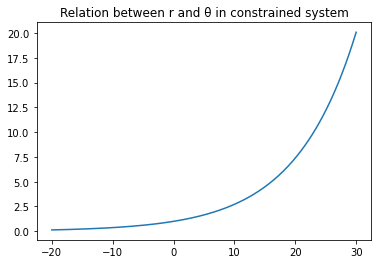

In [65]:
#plt.axis([-300, 300, -250, 250])
plt.plot(thetv_, rv_)
plt.title("Relation between r and θ in constrained system")

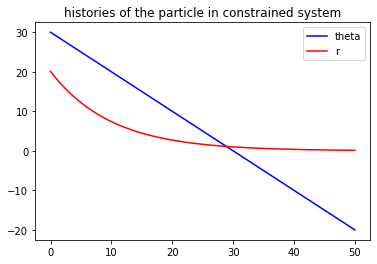

In [66]:
#plt.axis([0, 50, -30, 30])
plt.plot(t, thetv_,color='b', label='theta')
plt.plot(t, rv_, color='r', label='r')
plt.title("histories of the particle in constrained system")
plt.legend()
plt.show()

In [67]:
x = r*sp.cos(theta)
y = r*sp.sin(theta)
def get_xy(the, d):
    return (d*np.cos(the),
            d*np.sin(the))


x,y = get_xy(ans.T[0],ans.T[2])

Text(0.5, 1.0, 'Relation between r and θ in constrained system')

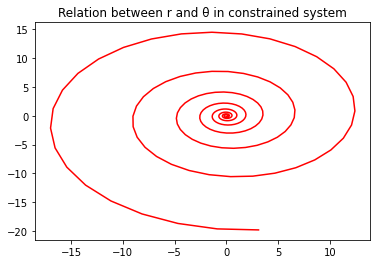

In [68]:
#plt.axis([-20, 15, -20, 15])
plt.plot(x, y,color='r')
plt.title("Relation between r and θ in constrained system")